In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dynamic_tasker.access import *
from dynamic_tasker.orbits import *
from dynamic_tasker.constants import *
from dynamic_tasker.cameras import *
from dynamic_tasker.schedulers import *

%load_ext autoreload
%autoreload 2

In [2]:
# Load world cities requests...
requests = load_worldcities(10000)

[ 51.6        -10.33745291]
[Access(7186, 53.2719, -9.0489, Galway, 2024-01-01 12:00:12.207031, 24.901537330328182, None, 1), Access(9874, 52.6653, -8.6238, Limerick, 2024-01-01 12:00:17.089844, 16.661695411027768, None, 1), Access(3000, 51.8972, -8.47, Cork, 2024-01-01 12:00:18.066406, 5.067121297449513, None, 1), Access(9987, 53.3544, -6.4486, Lucan, 2024-01-01 12:00:37.597656, 26.688934770432116, None, 1), Access(605, 53.35, -6.2603, Dublin, 2024-01-01 12:00:38.574219, 26.727444386984644, None, 1), Access(7357, 53.2886, -6.3572, Tallaght, 2024-01-01 12:00:38.574219, 25.906647800631056, None, 1), Access(2117, 53.4597, -6.2181, Finglas, 2024-01-01 12:00:39.550781, 28.076372336373428, None, 1), Access(2527, 50.3714, -4.1422, Plymouth, 2024-01-01 12:01:03.964844, -16.196920896268413, None, 1), Access(2742, 51.6167, -3.95, Abertawe, 2024-01-01 12:01:03.964844, 3.2627487185192496, None, 1), Access(5039, 50.7256, -3.5269, Exeter, 2024-01-01 12:01:08.847656, -10.37925513823351, None, 1), Ac

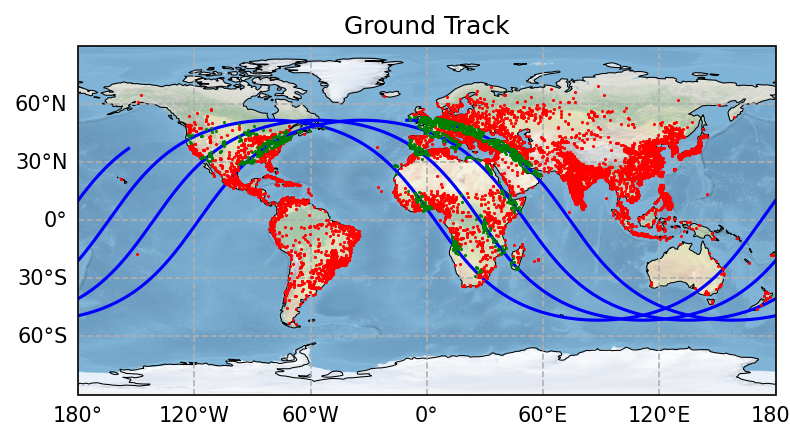

In [3]:
h = 400
t0 = datetime.datetime(2024, 1, 1, 12, 0, 0)
orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=datetime.datetime(2024, 1, 1, 12, 0, 0))
orbit = propagate_orbit(orbit, (t0 - orbit.t).total_seconds())
t_end = datetime.datetime(2024, 1, 1, 18, 0, 0)
# requests = [r for r in requests if r.name == "Hervey Bay"]
accesses = get_accesses(requests, orbit, 500, 30, t0, t_end)
seconds_since_epoch = (t0 - Constants.J2000).total_seconds()
print(ecef2latlong(eci2ecef((kepler2eci(orbit)[0]), t0)))

# Create a map with Cartopy
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
ax.set_global()

# Add features to the map
ax.stock_img()
# ax.add_feature(cfeature.LAND, facecolor='#A7C957')
# ax.add_feature(cfeature.OCEAN, facecolor='#A2D2FF')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False

print(accesses)

if(len(accesses) > 0):
    access_latlongs = np.unique(np.array([[a.lat, a.long] for a in accesses]), axis=0)
else:
    access_latlongs = []
    
req_latlongs = np.array([[x.lat, x.long] for x in requests if [x.lat, x.long] not in access_latlongs])

def split_orbit_track(latlongs, threshold=180):
    lat, long = np.array(latlongs)[:, 0], np.array(latlongs)[:, 1]
    # Calculate the difference between consecutive longitudes
    delta_long = np.abs(np.diff(long))
    
    # Identify where the jump exceeds the threshold
    jump_indices = np.where(delta_long > threshold)[0] + 1
    
    # Split the data at the jump indices
    segments = np.split(latlongs, jump_indices)
    return segments

ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
ax.set_title('Ground Track')

t_span = range(int((t_end - t0).total_seconds()))
segments = split_orbit_track([kepler2latlong(orbit, orbit.t + datetime.timedelta(seconds=t)) for t in t_span])
for i, segment in enumerate(segments):
    if len(segment) == 0:
        continue  # Skip empty segments
    ax.plot(
        segment[:, 1],
        segment[:, 0],
        color='blue',
        label=f"Orbit Track" if i == 0 else None,
        transform=ccrs.PlateCarree()
    )

ax.plot(req_latlongs[:, 1], req_latlongs[:, 0], '.r', markersize=1, label="All Requests", transform=ccrs.PlateCarree())
ax.plot(access_latlongs[:, 1], access_latlongs[:, 0], '.g', markersize=1, label="Obtained Accesses", transform=ccrs.PlateCarree())

plt.show()

In [4]:
t_s = 20
t_dot = 0.1

def agility(theta):
    return t_s + np.abs(t_dot * theta)

disjoint_graphs = []
i_last_cut = 0

for i, access in tqdm(enumerate(accesses)):
    def access_feasible(a1, a2):
        return a1.time + datetime.timedelta(seconds=agility(a1.angle)) <= a2.time
    
    # Are all future accesses feasible?
    # if(access_feasible(access, accesses[i+1])):
        # print("got one!")
    if(np.all([access_feasible(access, a) for a in accesses[i+1:]])):
        disjoint_graphs.append(accesses[i_last_cut:i+1])
        i_last_cut = i+1

disjoint_graphs.append(accesses[i_last_cut:])

1505it [00:03, 418.16it/s]


50


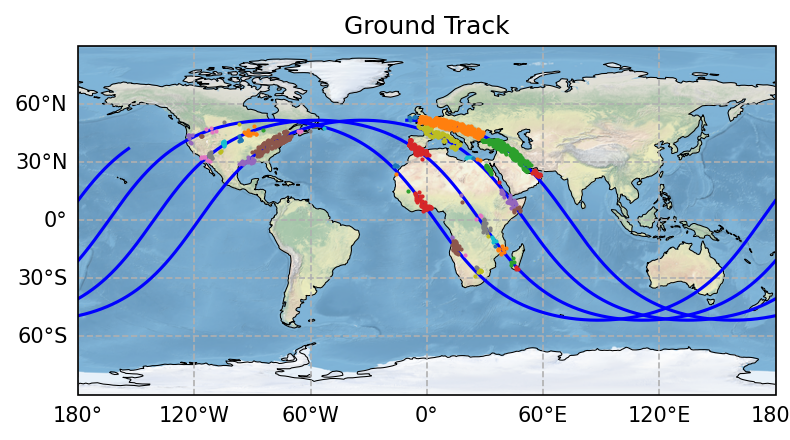

In [5]:
%matplotlib inline
# Create a map with Cartopy
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
ax.set_global()

# Add features to the map
ax.stock_img()
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False

def split_orbit_track(latlongs, threshold=180):
    lat, long = np.array(latlongs)[:, 0], np.array(latlongs)[:, 1]
    # Calculate the difference between consecutive longitudes
    delta_long = np.abs(np.diff(long))
    
    # Identify where the jump exceeds the threshold
    jump_indices = np.where(delta_long > threshold)[0] + 1
    
    # Split the data at the jump indices
    segments = np.split(latlongs, jump_indices)
    return segments

t_span = range(int((t_end - t0).total_seconds()))
segments = split_orbit_track([kepler2latlong(orbit, orbit.t + datetime.timedelta(seconds=t)) for t in t_span])
for i, segment in enumerate(segments):
    if len(segment) == 0:
        continue  # Skip empty segments
    ax.plot(
        segment[:, 1],
        segment[:, 0],
        color='blue',
        label=f"Orbit Track" if i == 0 else None,
        transform=ccrs.PlateCarree()
    )


ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
ax.set_title('Ground Track')

print(len(disjoint_graphs))
for g in disjoint_graphs:
    ax.plot([a.long for a in g], [a.lat for a in g], '.', markersize=2)

plt.show()

100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


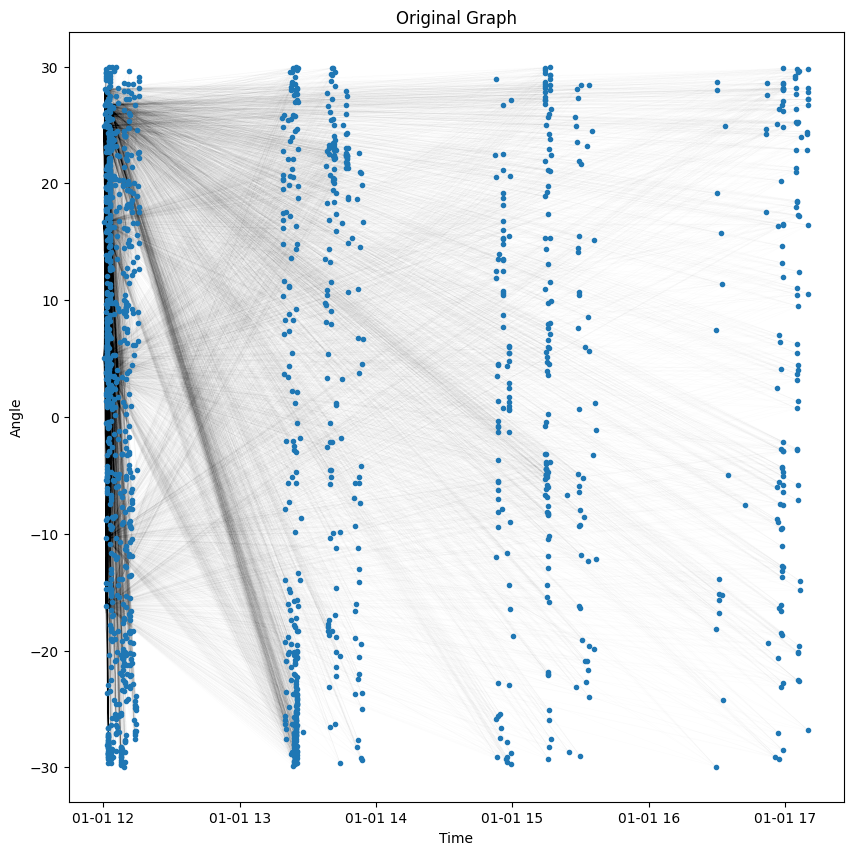

In [6]:
# Plot the original graph

t_s = 10
t_dot = 4
def agility_bangbang(theta):
    return t_s + np.sqrt(np.abs(t_dot * theta))

plt.figure(figsize=(10, 10))

# Now go through and plot all the feasible transitions
for a in tqdm(accesses[0:10]):
    accesses_filtered = [x for x in accesses if x.time > a.time + datetime.timedelta(seconds=agility_bangbang(x.angle - a.angle))]
    for b in accesses_filtered:
        plt.plot([a.time, b.time], [a.angle, b.angle], 'k', linewidth=0.5, alpha=0.01)

plt.plot([a.time for a in accesses], [a.angle for a in accesses], '.')



# plt.grid(True)

plt.xlabel('Time') 
plt.ylabel('Angle')
plt.title('Original Graph')
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


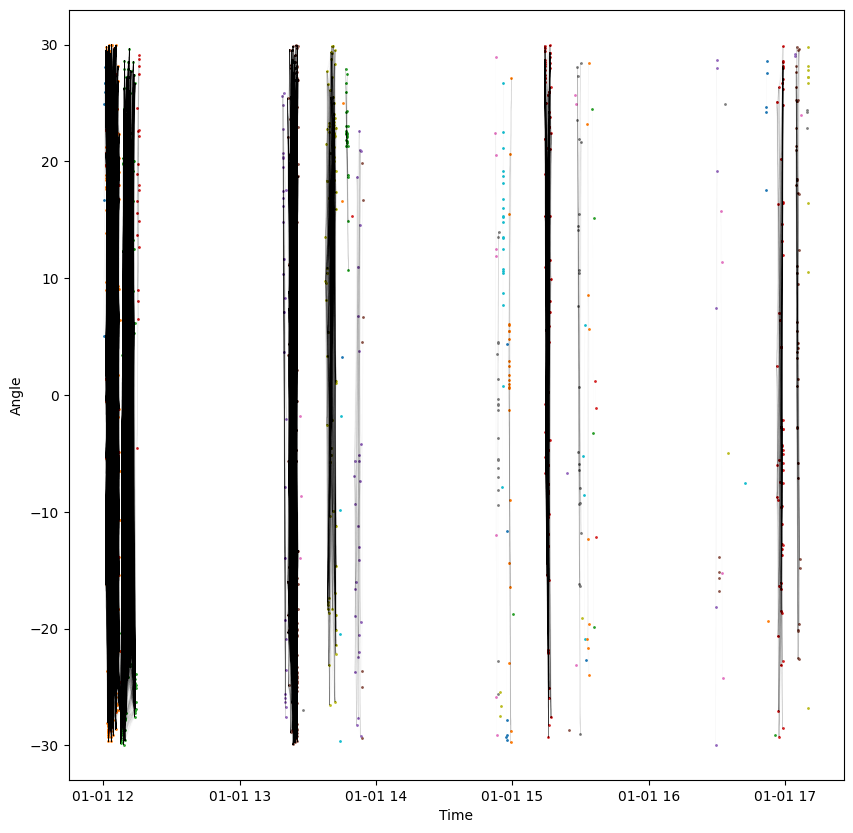

In [ ]:
# Now do the same for the disjoint graphs

plt.figure(figsize=(10, 10))

for g in tqdm(disjoint_graphs):
    plt.plot([a.time for a in g], [a.angle for a in g], '.', markersize=2)
    for a in g:
        accesses_filtered = [x for x in g if x.time > a.time + datetime.timedelta(seconds=agility_bangbang(x.angle - a.angle))]
        for b in accesses_filtered:
            plt.plot([a.time, b.time], [a.angle, b.angle], 'k', linewidth=0.5, alpha=0.01)

plt.xlabel('Time')
plt.ylabel('Angle')
plt.show()